In [1]:
%cd /Users/helloworld/Home/Desktop/amugeona

/Users/helloworld/Home/Desktop/amugeona


In [2]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import math

In [3]:
import session_info
session_info.show()

2D heat eqn:

∂u/∂t = α∇²u = α(∂²u/∂x² + ∂²u/∂z²)

where:
- u(x,z,t) is the temperature field
- α is the thermal diffusivity
- ∇² is the Laplacian operator

Fourier's law of heat conduction -- heat flows with rate proportional to the temperature gradient

At steady state (t → ∞), ∂u/∂t = 0, which givesLaplace eqn: ∇²u = 0

Boundary conditions
- Top (z = D): Dirichlet BC → u = 50 + 50·sin(2π·5x/L)
- Bottom (z = 0): Neumann BC → ∂u/∂z = 0 (insulated, zero flux)
- Left & Right: Periodic BC → u(0,z) = u(L,z)

using implicit euler time stepping with finite differences (stable)

In [4]:
# physical parameters
L_in_cm = 50  # Length in cm of the 2D domain you are modeling
D_in_cm = 5   # Depth in cm of the domain you are modeling
thermal_diffusivity = 0.1  # Thermal diffusivity (cm²/s)
total_time_in_sec = 50.0  # Total simulation time

In [5]:
# non-dimensionalization
Unit_length_in_cm = 5
Unit_time_in_sec = 1.0

In [6]:
# numerical constants
nx = 500  # Number of partitions of the domain in the x direction
nz = 100   # Number of partitions of the domain in the z direction
nt = 500  # Number of time steps


In [7]:
# dimensionless params
L = L_in_cm / Unit_length_in_cm
D = D_in_cm / Unit_length_in_cm
alpha = thermal_diffusivity * Unit_time_in_sec / (Unit_length_in_cm**2)
T_total = total_time_in_sec / Unit_time_in_sec

In [8]:
# derived numerical constants
delta_x = L / nx
delta_z = D / nz
delta_t = T_total / nt
gamma_x = alpha * delta_t / (delta_x**2)
gamma_z = alpha * delta_t / (delta_z**2)

print(f"Stability parameter (gamma_x): {gamma_x:.4f}")
print(f"Stability parameter (gamma_z): {gamma_z:.4f}")

# for explicit method, need gamma_x + gamma_z < 0.5
# using implicit method (unconditionally stable)

Stability parameter (gamma_x): 1.0000
Stability parameter (gamma_z): 4.0000


In [9]:
# boundary/initial conditions
def Dirichlet_cond_top(x, t):
    """
    Temperature at the top boundary
    just used 50 + 50*sin(...) to make temps are positive
    """
    return 50.0 + 50.0 * np.sin(2*math.pi*5*x/L)  # Range: 0 to 100

def Neumann_cond_bottom():
    """Bottom boundary condition: Insulated (zero heat flux) ∂u/∂z = 0 at z = 0"""
    return 0.0

def initial_condition(x, z):
    """Initial temperature distribution"""
    return 0.0  # Start cold everywhere

In [10]:
# array initialization
u = np.zeros((nz, nx))  # Current temperature field

# Set initial condition
for i in range(nz):
    for j in range(nx):
        x_pos = j * delta_x
        z_pos = i * delta_z
        u[i, j] = initial_condition(x_pos, z_pos)

In [11]:
# index conversion func
def to_1d_index(i, j):
    """Convert 2D indices (i,j) to 1D index"""
    return i * nx + j

def to_2d_index(idx):
    """Convert 1D index to 2D indices (i,j)"""
    i = idx // nx
    j = idx % nx
    return i, j

In [12]:
# implicit euler, build system matrix
num_unknowns = nz * nx
A = lil_matrix((num_unknowns, num_unknowns))

# Coefficient for the center node: 1 + 2γ_x + 2γ_z
coeff_center = 1.0 + 2.0*gamma_x + 2.0*gamma_z

for i in range(nz):
    for j in range(nx):
        eq_idx = to_1d_index(i, j)
        
        # Center node contribution (always present)
        A[eq_idx, eq_idx] = coeff_center
        
        # Right neighbor (periodic boundary condition in x-direction)
        if j < (nx - 1):
            neighbor_idx = to_1d_index(i, j + 1)
        else:
            neighbor_idx = to_1d_index(i, 0)  # Wrap around to left edge
        A[eq_idx, neighbor_idx] = -gamma_x
        
        # Left neighbor (periodic boundary condition in x-direction)
        if j > 0:
            neighbor_idx = to_1d_index(i, j - 1)
        else:
            neighbor_idx = to_1d_index(i, nx - 1)  # Wrap around to right edge
        A[eq_idx, neighbor_idx] = -gamma_x
        
        # Top neighbor (Dirichlet BC handled in RHS)
        if i < (nz - 1):
            neighbor_idx = to_1d_index(i + 1, j)
            A[eq_idx, neighbor_idx] = -gamma_z
        # If i == nz-1 (top), no neighbor above
        
        # Bottom neighbor (Neumann BC: ∂u/∂z = 0 at bottom)
        if i > 0:
            neighbor_idx = to_1d_index(i - 1, j)
            A[eq_idx, neighbor_idx] = -gamma_z
        else:
            # Mirror condition: u[-1,j] = u[1,j] ⇒ double the upper neighbor
            neighbor_idx = to_1d_index(i + 1, j)
            A[eq_idx, neighbor_idx] = -2.0 * gamma_z

A_csr = A.tocsr()

In [13]:
u_history = []
time_points = []
save_every = max(1, nt // 100)  # Save 100 frames

In [14]:
# time stepping
for n in range(nt):
    # t_{n+1}: implicit scheme using next-time boundary 
    t_np1 = (n + 1) * delta_t
    
    # Build right-hand side vector b
    b = np.zeros(num_unknowns)
    
    for i in range(nz):
        for j in range(nx):
            eq_idx = to_1d_index(i, j)
            
            # Start with current temperature (from backward Euler)
            b[eq_idx] = u[i, j]
            
            # Apply Dirichlet BC at top boundary (i = nz-1)
            # Move missing neighbor term to RHS: +γ_z * T_top at t_{n+1}
            if i == (nz - 1):
                x_pos = j * delta_x
                T_top = Dirichlet_cond_top(x_pos, t_np1)  
                b[eq_idx] += gamma_z * T_top
    
    # Solve the linear system: A * u_new = b
    vec = spsolve(A_csr, b)
    
    # Update temperature field
    for idx in range(num_unknowns):
        i, j = to_2d_index(idx)
        u[i, j] = vec[idx]
    
    # Store for visualization
    if n % save_every == 0:
        u_history.append(u.copy())
        time_points.append((n + 1) * delta_t)  # store t_{n+1} for consistency
    
    # Print progress
    if (n + 1) % (nt // 10) == 0:
        print(f"Progress: {100*(n+1)/nt:.0f}% (t = {(n+1)*delta_t:.2f})")

Progress: 10% (t = 5.00)
Progress: 20% (t = 10.00)
Progress: 30% (t = 15.00)
Progress: 40% (t = 20.00)
Progress: 50% (t = 25.00)
Progress: 60% (t = 30.00)
Progress: 70% (t = 35.00)
Progress: 80% (t = 40.00)
Progress: 90% (t = 45.00)
Progress: 100% (t = 50.00)


In [15]:
# calculate heat flux vector field
k = 1.0  # Thermal conductivity (set to 1 for simplicity)
q_x = np.zeros((nz, nx))  # Horizontal heat flux
q_z = np.zeros((nz, nx))  # Vertical heat flux

# Calculate horizontal flux q_x = -k(∂u/∂x)
for i in range(nz):
    for j in range(nx):
        if j == 0:  # Left boundary (periodic)
            q_x[i, j] = -k * (u[i, 1] - u[i, nx - 1]) / (2 * delta_x)
        elif j == nx - 1:  # Right boundary (periodic)
            q_x[i, j] = -k * (u[i, 0] - u[i, nx - 2]) / (2 * delta_x)
        else:  # Interior point
            q_x[i, j] = -k * (u[i, j + 1] - u[i, j - 1]) / (2 * delta_x)

# Calculate vertical flux q_z = -k(∂u/∂z)
for i in range(nz):
    for j in range(nx):
        if i == 0:  # Bottom boundary (Neumann: zero flux is already enforced)
            q_z[i, j] = -k * (u[i + 1, j] - u[i, j]) / delta_z
        elif i == nz - 1:  # Top boundary
            q_z[i, j] = -k * (u[i, j] - u[i - 1, j]) / delta_z
        else:  # Interior point
            q_z[i, j] = -k * (u[i + 1, j] - u[i - 1, j]) / (2 * delta_z)

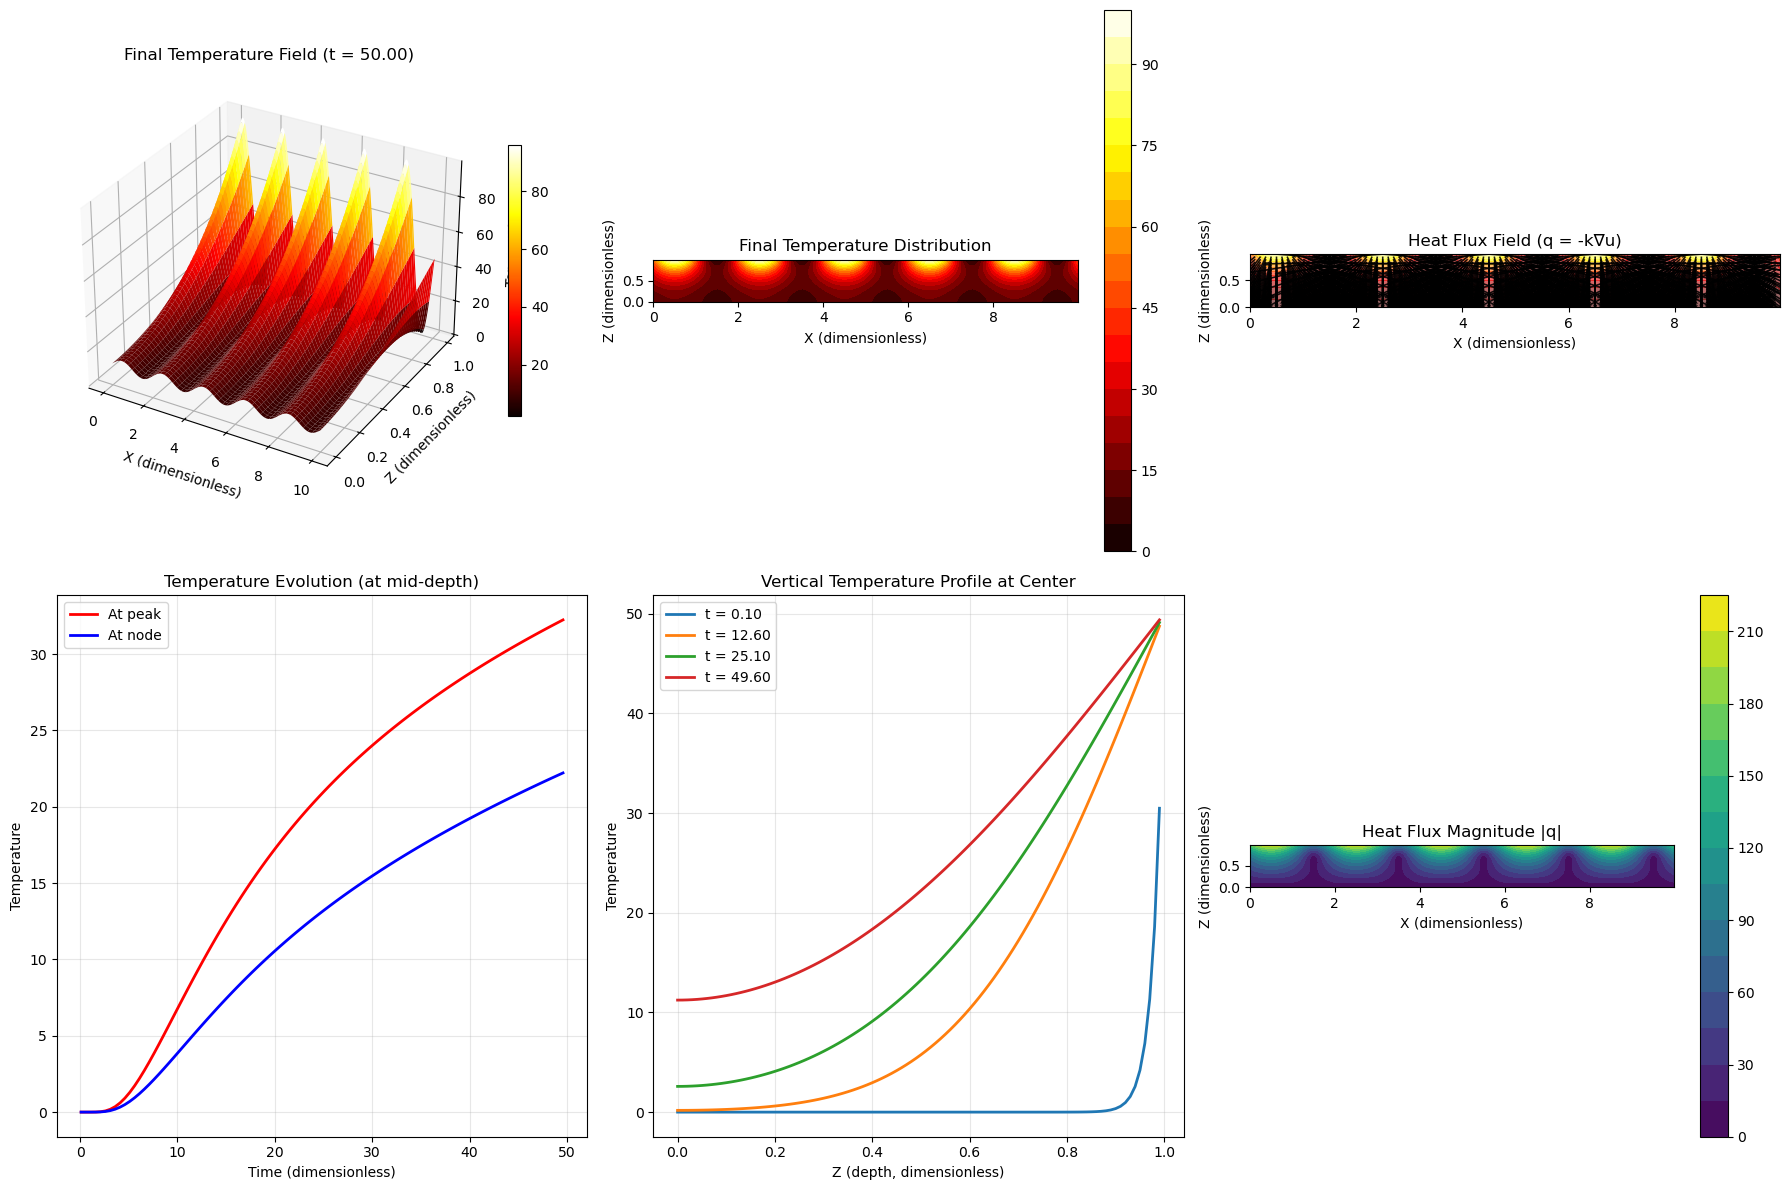

In [16]:
# plotting
# used some AI here for visualization
# Create coordinate arrays
x_vec = np.array([j * delta_x for j in range(nx)])
z_vec = np.array([i * delta_z for i in range(nz)])
X_mat, Z_mat = np.meshgrid(x_vec, z_vec)

# Create figure with multiple subplots (3x2 layout)
fig = plt.figure(figsize=(18, 12))

# Plot 1: 3D surface of final temperature
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
surf = ax1.plot_surface(X_mat, Z_mat, u, cmap=cm.hot,
                        linewidth=0, antialiased=True)
ax1.set_xlabel('X (dimensionless)')
ax1.set_ylabel('Z (dimensionless)')
ax1.set_zlabel('Temperature')
ax1.set_title(f'Final Temperature Field (t = {T_total:.2f})')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# Plot 2: 2D heatmap of final temperature
ax2 = fig.add_subplot(2, 3, 2)
im = ax2.contourf(X_mat, Z_mat, u, levels=20, cmap=cm.hot)
ax2.set_xlabel('X (dimensionless)')
ax2.set_ylabel('Z (dimensionless)')
ax2.set_title('Final Temperature Distribution')
ax2.set_aspect('equal')
fig.colorbar(im, ax=ax2)

# Plot 3: Heat flux vector field
ax3 = fig.add_subplot(2, 3, 3)
skip = 5  # Plot every 5th arrow for better visualization
X_sub = X_mat[::skip, ::skip]
Z_sub = Z_mat[::skip, ::skip]
qx_sub = q_x[::skip, ::skip]
qz_sub = q_z[::skip, ::skip]

# Overlay temperature contours with heat flux vectors
ax3.contourf(X_mat, Z_mat, u, levels=15, cmap=cm.hot, alpha=0.6)
ax3.quiver(X_sub, Z_sub, qx_sub, qz_sub, scale=500, alpha=0.9, width=0.003)
ax3.set_xlabel('X (dimensionless)')
ax3.set_ylabel('Z (dimensionless)')
ax3.set_title('Heat Flux Field (q = -k∇u)')
ax3.set_aspect('equal')

# Plot 4: Temperature evolution at multiple points
ax4 = fig.add_subplot(2, 3, 4)
# Track temperature at a peak of sine: x = (2m+1)L/20 ⇒ j = nx/20 (FIX #2)
peak_j = nx // 20  # FIX #2 here
center_i = nz // 2
peak_temps = [u_hist[center_i, peak_j] for u_hist in u_history]
ax4.plot(time_points, peak_temps, 'r-', linewidth=2, label='At peak')
# Also track at a node (where sin is zero): x = m L/10 ⇒ j = nx/10
node_j = nx // 10
node_temps = [u_hist[center_i, node_j] for u_hist in u_history]
ax4.plot(time_points, node_temps, 'b-', linewidth=2, label='At node')
ax4.set_xlabel('Time (dimensionless)')
ax4.set_ylabel('Temperature')
ax4.set_title(f'Temperature Evolution (at mid-depth)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Vertical Temperature Profile at Center
ax5 = fig.add_subplot(2, 3, 5)
for idx in [0, len(u_history)//4, len(u_history)//2, -1]:
    label_time = time_points[idx]
    ax5.plot(z_vec, u_history[idx][:, nx//2], 
             label=f't = {label_time:.2f}', linewidth=2)
ax5.set_xlabel('Z (depth, dimensionless)')
ax5.set_ylabel('Temperature')
ax5.set_title('Vertical Temperature Profile at Center')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Magnitude of heat flux
ax6 = fig.add_subplot(2, 3, 6)
q_magnitude = np.sqrt(q_x**2 + q_z**2)
im6 = ax6.contourf(X_mat, Z_mat, q_magnitude, levels=20, cmap=cm.viridis)
ax6.set_xlabel('X (dimensionless)')
ax6.set_ylabel('Z (dimensionless)')
ax6.set_title('Heat Flux Magnitude |q|')
ax6.set_aspect('equal')
fig.colorbar(im6, ax=ax6)

plt.tight_layout()
plt.show()


In [17]:
%pip install pillow

Note: you may need to restart the kernel to use updated packages.


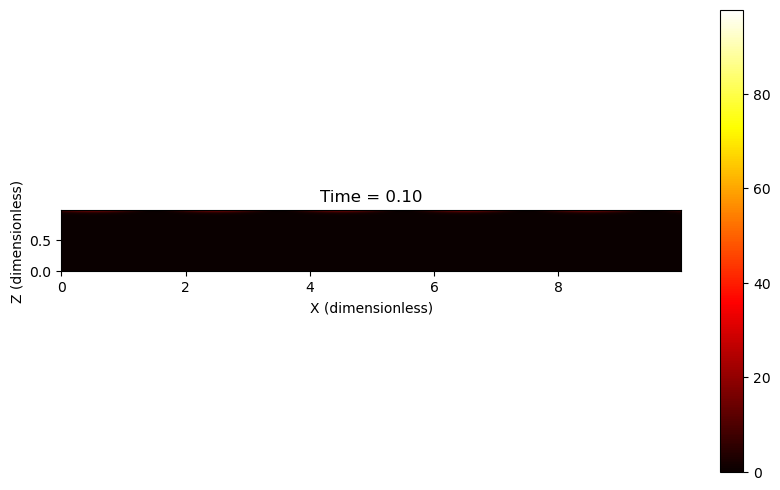

In [18]:
from matplotlib import rc
from matplotlib.animation import PillowWriter
rc('animation', html='jshtml')

# --- 애니메이션 블록: 이걸로 통째로 교체하세요 ---
from IPython.display import HTML
from matplotlib import cm
from matplotlib.animation import FuncAnimation
import numpy as np

fig_anim, ax_anim = plt.subplots(figsize=(10, 6))

# 전체 프레임 기준으로 색 범위 고정 (깜빡임 방지)
vmin = min(np.min(frame) for frame in u_history)
vmax = max(np.max(frame) for frame in u_history)

im = ax_anim.imshow(
    u_history[0],
    origin='lower',
    extent=[X_mat.min(), X_mat.max(), Z_mat.min(), Z_mat.max()],
    aspect='equal',
    cmap=cm.hot,
    vmin=vmin, vmax=vmax
)
ax_anim.set_xlabel('X (dimensionless)')
ax_anim.set_ylabel('Z (dimensionless)')
title = ax_anim.set_title(f'Time = {time_points[0]:.2f}')
cbar = fig_anim.colorbar(im, ax=ax_anim)

def animate(frame):
    im.set_data(u_history[frame])
    title.set_text(f'Time = {time_points[frame]:.2f}')
    return [im, title]

anim = FuncAnimation(
    fig_anim, animate,
    frames=len(u_history),
    interval=100, blit=False, repeat=True
)

# VSCode Jupyter에서 확실히 보이도록 HTML로 렌더
HTML(anim.to_jshtml())


writer = PillowWriter(fps=10, metadata={"loop": 0})  # 0 = 무한 반복
anim.save('heat2d.gif', writer=writer, dpi=120)
